In [1]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane import AngleEmbedding, AmplitudeEmbedding


In [2]:
# U='U_TTN'
# U_p=2
# U='U_9'
# U_p=2
# U='U_15'
# U_p=4
# U='U_13'
# U_p=6
# U='U_14'
# U_p=6
U='U_SO4'
U_p=6
# U='U_5'
# U_p=10
# U='U_6'
# U_p=10
# U='U_SU4'
# U_p=15

totol_params=2*U_p+2


torch.manual_seed(42)
np.random.seed(42)


os.environ["OMP_NUM_THREADS"] = "1"

step = 0.003               # Learning rate
batch_size = 32              # Number of samples for each training step
num_epochs = 50              # Number of training epochs

gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

train_all_loss=[]
train_all_acc=[]
val_all_loss=[]
val_all_acc=[]
best_accuracy=0

device = torch.device("cpu")

In [3]:
train_f=[[61, 222, 331, 823, 849, 988, 1169, 1218, 1589, 2118, 2962, 3009, 3086, 3227, 3432, 3903, 3980, 4325, 4511, 5353, 5563, 5604, 5702, 5703, 5751, 5792, 5947, 6165, 6563, 7321, 7426, 7651, 7667, 7694, 7803, 8030, 8245, 8699, 8743, 8990, 9208, 9374, 9930, 9969, 10309, 10562, 10765, 10902, 11027, 11332, 11518, 11618, 11789, 11840, 12151, 12268, 12391, 12467, 12559, 12565, 12830, 12887, 12896, 13360, 13544, 13915, 14313, 14382, 14395, 14580, 14718, 14737, 14781, 15052, 15301, 15402, 15775, 16199, 16568, 16594, 16661, 16965, 17029, 17071, 17089, 17191, 17521, 17706, 17746, 18429, 18865, 19012, 19217, 19268, 20033, 20293, 20468, 20704, 21249, 21279, 21550, 21750, 21817, 22216, 22218, 22505, 22718, 22778, 23237, 23254, 23655, 24058, 24076, 24429, 24550, 24651, 24689, 24851, 24853, 24972, 25162, 25465, 25529, 25830, 25903, 26440, 26441, 26460, 26663, 26798, 27232, 27344, 27371, 27525, 27589, 27799, 28277, 28572, 28941, 28971, 29073, 29100, 29159, 29516, 29614, 29832, 30181, 30237, 30256, 30291, 30453, 30476, 30640, 31029, 31491, 31493, 31512, 31815, 32166, 32575, 32761, 32905, 32967, 33165, 33296, 33872, 34308, 34433, 34528, 34560, 34603, 34674, 34703, 35500, 35676, 35721, 35841, 36021, 36379, 36542, 36615, 36633, 36644, 37636, 37747, 37942, 37987, 38212, 38264, 38369, 38825, 38887, 38971, 39330, 39594, 39873, 40359, 40421, 40528, 40552, 40680, 40776, 40835, 40879, 40938, 40991, 42786, 42802, 42924, 42999, 43122, 43183, 43703, 43871, 44450, 44825, 44947, 45526, 45689, 45849, 46131, 46285, 46498, 46554, 47109, 47323, 47356, 47761, 47778, 47874, 48023, 48458, 48609, 48734, 48964, 49019, 49207, 49223, 49591, 50087, 50089, 50096, 50200, 50204, 50303, 50564, 50810, 50811, 50830, 51146, 51490, 51801, 51877, 51915, 52402, 52435, 52601, 52660, 52857, 52981, 53338, 53542, 53589, 53823, 53837, 53855, 54058, 54283, 54603, 54706, 54710, 54795, 55127, 55274, 55506, 55595, 55911, 56066, 56205, 56243, 56282, 56294, 56409, 56507, 56623, 56628, 56636, 56637, 56689, 56696, 56752, 57238, 57524, 57534, 58456, 59114, 59241, 59385, 59405, 59803], [283, 307, 385, 517, 685, 805, 959, 1132, 1203, 1365, 1514, 1686, 2117, 2145, 2344, 2421, 2808, 2974, 3109, 3212, 3792, 4004, 4336, 4345, 4349, 4431, 4642, 4697, 4769, 4850, 4875, 4904, 4962, 5090, 5097, 5512, 5543, 6031, 6109, 6296, 6504, 6608, 6777, 6904, 7038, 7258, 7896, 8038, 8135, 8500, 9078, 9105, 9118, 9182, 9355, 9830, 10109, 10154, 10185, 10512, 11043, 11184, 11189, 11429, 11702, 11887, 12181, 12307, 12422, 12480, 12481, 12492, 12940, 13101, 13264, 13475, 14361, 14399, 14754, 15045, 16156, 16321, 16345, 16520, 16579, 16976, 17225, 17326, 17400, 17903, 18113, 18220, 18333, 18433, 18661, 18776, 19059, 19226, 19434, 19728, 19831, 19846, 19892, 20075, 20495, 20689, 20812, 20877, 21213, 21233, 21420, 21480, 22005, 22263, 22376, 22396, 22418, 22438, 22724, 23004, 23164, 23378, 23750, 23861, 24223, 24449, 24563, 24791, 24926, 25070, 25185, 25430, 25587, 25642, 25893, 26227, 26368, 26499, 26505, 26640, 26700, 26846, 27117, 27220, 27234, 27418, 27436, 27451, 27493, 27538, 27661, 27854, 27875, 27957, 29298, 29533, 30101, 30134, 30221, 30235, 30364, 30542, 30654, 30772, 31072, 31347, 31397, 31459, 31584, 31685, 31719, 32308, 32414, 32561, 32962, 33162, 33376, 33680, 33853, 33900, 34108, 34193, 34253, 34309, 34362, 34445, 34527, 35206, 36035, 36156, 36181, 36206, 36840, 37117, 37460, 37562, 37648, 37670, 37737, 37848, 38221, 38368, 39046, 39160, 39234, 39612, 40231, 40505, 40615, 40667, 40790, 41045, 41096, 41463, 41748, 41773, 42201, 42324, 42377, 42550, 42606, 42608, 42777, 42781, 42805, 42934, 42941, 43257, 43349, 43367, 43585, 43669, 43774, 43815, 44042, 44137, 44220, 44528, 44800, 45120, 45217, 45537, 45554, 46936, 47104, 47263, 47440, 47871, 47911, 48306, 48486, 48561, 48667, 48877, 49308, 49534, 49660, 49807, 49919, 50103, 50151, 50847, 51077, 51111, 51536, 52030, 52068, 52142, 52217, 53060, 53199, 53260, 53442, 53445, 53592, 53614, 53690, 53947, 53951, 54466, 54724, 55734, 55841, 55879, 56654, 57217, 57300, 57376, 57861, 58339, 58382, 58444, 58579, 58692, 58771, 58848, 58987, 59706, 59717, 59931], [544, 855, 1372, 1588, 1651, 1851, 1918, 2088, 2572, 2678, 3097, 3124, 3625, 3858, 3912, 3950, 4020, 4327, 4396, 4768, 5027, 5158, 5554, 5717, 5842, 5871, 6235, 6293, 6451, 6598, 6709, 6764, 6833, 6960, 7219, 8725, 9083, 9122, 9309, 9397, 9891, 10340, 10706, 10766, 10828, 10939, 10946, 11501, 11715, 11814, 11915, 12137, 12188, 12295, 12377, 12412, 12824, 13006, 13100, 13306, 13310, 13711, 13917, 14387, 14588, 14746, 15066, 15274, 15779, 16412, 16493, 16506, 16650, 16652, 16826, 16910, 17620, 17667, 17697, 17813, 18100, 18142, 18160, 18394, 18597, 18781, 18815, 19003, 19018, 19335, 19480, 19830, 19841, 19862, 20542, 20748, 21502, 21864, 21961, 22056, 22375, 22407, 22514, 22622, 22670, 22704, 22756, 22789, 22847, 23240, 23430, 23438, 23589, 23663, 23677, 23716, 24020, 24569, 24592, 24720, 24961, 25933, 26500, 26509, 26684, 26876, 26947, 27033, 27129, 27565, 27649, 27742, 27845, 28060, 28163, 28369, 28445, 28619, 28624, 28804, 28919, 29020, 29215, 29226, 29232, 29276, 29286, 29320, 29372, 29423, 29432, 29502, 29508, 29625, 29718, 29831, 30255, 30563, 30578, 30752, 31154, 31445, 31503, 31506, 31934, 32263, 32354, 32782, 33068, 33137, 33621, 34593, 35052, 35380, 35828, 36280, 36484, 36665, 37045, 37301, 37509, 37819, 38010, 38049, 38064, 38508, 38752, 39000, 39847, 40035, 40320, 40843, 41107, 41212, 41625, 41704, 41729, 41870, 42023, 42224, 42720, 43197, 43225, 43454, 43700, 44031, 44190, 44513, 44767, 44878, 44918, 45009, 45010, 45102, 45431, 45522, 45848, 46196, 46391, 46652, 46828, 46847, 47022, 47029, 47068, 47157, 47243, 47413, 47568, 47628, 47667, 47716, 48027, 48102, 48214, 48399, 48651, 48714, 48867, 49176, 49222, 49257, 49305, 49458, 49545, 49715, 49893, 50004, 50154, 50166, 50190, 50597, 50654, 50738, 51072, 51526, 51632, 51770, 52088, 52229, 52450, 52505, 52584, 52614, 52666, 52733, 52771, 52966, 53108, 53200, 53511, 53550, 53729, 53758, 53923, 54086, 54141, 54343, 54591, 55075, 55241, 55287, 55669, 55776, 55854, 55899, 56161, 56169, 56394, 56472, 57137, 57749, 58006, 58746, 58994, 59039, 59432, 59643, 59895, 59977], [31, 114, 204, 686, 709, 871, 1787, 1825, 1937, 1987, 1997, 3012, 3737, 4060, 4114, 4320, 4481, 4555, 5259, 5447, 5586, 5610, 5675, 5878, 6052, 6140, 6537, 6695, 6854, 7030, 7043, 7112, 7375, 7617, 7782, 8045, 8097, 8102, 8378, 8585, 8959, 9051, 9101, 9462, 9625, 9782, 9806, 9877, 9918, 9958, 10050, 11226, 11301, 11546, 11986, 12150, 12323, 12501, 12695, 12811, 12960, 13266, 13304, 13305, 13977, 13982, 14277, 14611, 14831, 14857, 14994, 15047, 15561, 15681, 16023, 16057, 16122, 16313, 16406, 16452, 16567, 16739, 17701, 18107, 18109, 18216, 18602, 19465, 19551, 19723, 20038, 20097, 20206, 20210, 20274, 20351, 20632, 20947, 21187, 21549, 21727, 21933, 22033, 22165, 22347, 22618, 22899, 22964, 23487, 23618, 23708, 23976, 24096, 24288, 24562, 24699, 24724, 25283, 25684, 25796, 25975, 26101, 26178, 26650, 26734, 26832, 26837, 27351, 27562, 28119, 28160, 28170, 28345, 28625, 29138, 29179, 29195, 29211, 29450, 29624, 29651, 29703, 30001, 30268, 30527, 30662, 30779, 30842, 31052, 31259, 31289, 31718, 32259, 32399, 33386, 33987, 33997, 34054, 34128, 34160, 34246, 34499, 34533, 34615, 34906, 35062, 35163, 35274, 35894, 35911, 35926, 36046, 36566, 37373, 37606, 37634, 37720, 37802, 38307, 38378, 38670, 38944, 38957, 39478, 39787, 39965, 40307, 40584, 40859, 41132, 41329, 41476, 41583, 42110, 42139, 42255, 42631, 42725, 42747, 42808, 42835, 42842, 42904, 43522, 43739, 44107, 44122, 44172, 44213, 44455, 44504, 44653, 44717, 44942, 45299, 45613, 45809, 46041, 46082, 46306, 46341, 46443, 46557, 46824, 46992, 47166, 47294, 47414, 47743, 48125, 48469, 48832, 49830, 50046, 50135, 50244, 50413, 50487, 50604, 50660, 50758, 50949, 51010, 51022, 51076, 51168, 51365, 51530, 51599, 51634, 51693, 51705, 51707, 52079, 52297, 52457, 52517, 52628, 52668, 52678, 52718, 52750, 52849, 53044, 53067, 53161, 53356, 53413, 53448, 53655, 54122, 54324, 54602, 54609, 54638, 54659, 54786, 55699, 55719, 55789, 56207, 56547, 56769, 57092, 57100, 57173, 57954, 58164, 58179, 58195, 58342, 58458, 58609, 58734, 58782, 58980, 59369, 59697, 59892, 59980], [311, 399, 426, 923, 1021, 1184, 1283, 1330, 1577, 2333, 2451, 2493, 2599, 2714, 2715, 2941, 2945, 3182, 3866, 3907, 4246, 4384, 4538, 5006, 5418, 5595, 5664, 5738, 5772, 5840, 5935, 5958, 6002, 6055, 6124, 6148, 6259, 6445, 6769, 7448, 7517, 7632, 7707, 7792, 8180, 8624, 8728, 8787, 8979, 9066, 9344, 9560, 9793, 10323, 10583, 10623, 10809, 11381, 11500, 11526, 11731, 11842, 11982, 12086, 12102, 12160, 12392, 12461, 12586, 12730, 12985, 13396, 13558, 13613, 13751, 13845, 13901, 14035, 14139, 14269, 14274, 14318, 14348, 14684, 14774, 14845, 14888, 15040, 15204, 15520, 15805, 16006, 16206, 17007, 17026, 17033, 17103, 17126, 17421, 17495, 17554, 17564, 17682, 17955, 17995, 18417, 18886, 19320, 19373, 19475, 19492, 19565, 19569, 19857, 20106, 20414, 20560, 21507, 21830, 21891, 22134, 22474, 23000, 23289, 23339, 23502, 23866, 24051, 24087, 24107, 24191, 24345, 24384, 24584, 24652, 24751, 24815, 24848, 24921, 25038, 25186, 25431, 25670, 25935, 26037, 26394, 26514, 27448, 27533, 27632, 27658, 27675, 27710, 27719, 27731, 27822, 28132, 28318, 28419, 28427, 28501, 28586, 28589, 28595, 28739, 28813, 28836, 29218, 29254, 29347, 29570, 29707, 29825, 30262, 30264, 30335, 30973, 31310, 31490, 31710, 32513, 32730, 32745, 32777, 32987, 33133, 33305, 33462, 33926, 34071, 34239, 34273, 34286, 34305, 34587, 34847, 35009, 35723, 35764, 35826, 36146, 36277, 36457, 36994, 37095, 37169, 37321, 37411, 37457, 37805, 38052, 38138, 39254, 39651, 39683, 39934, 40198, 40386, 40599, 40671, 40747, 40756, 41112, 41280, 42170, 42508, 42933, 43423, 43553, 43730, 43744, 43754, 43769, 43894, 44084, 44248, 44670, 44788, 44845, 44934, 45369, 45896, 46319, 47337, 47403, 47522, 47656, 47662, 47733, 47904, 47916, 48058, 48105, 48168, 48242, 48716, 48751, 48829, 48852, 48956, 49939, 50173, 50779, 51560, 52110, 52220, 52633, 52766, 53331, 53434, 54032, 54059, 54753, 55674, 55894, 55969, 56333, 56820, 56973, 57211, 57233, 57311, 57699, 57876, 57914, 57998, 58015, 58160, 58545, 58635, 58639, 58777, 58817, 58833, 59048, 59304, 59341, 59462, 59467, 59963], [230, 345, 614, 620, 705, 1058, 1781, 1841, 1984, 2134, 2157, 2227, 2533, 3088, 3138, 3230, 3261, 3486, 3531, 3820, 4204, 4303, 4311, 4861, 4961, 5093, 5377, 5558, 5591, 5623, 5749, 5951, 6027, 6636, 6661, 7316, 7539, 7974, 8171, 8366, 8376, 8778, 8946, 9030, 9125, 9195, 9440, 9543, 10008, 10165, 10423, 10555, 10687, 10697, 10794, 10998, 11011, 11026, 11263, 11271, 11542, 11594, 11691, 12166, 12304, 12603, 12748, 12876, 13218, 13444, 13447, 13782, 14190, 14524, 14983, 14993, 15372, 15422, 15496, 15574, 15599, 15634, 15796, 15878, 16354, 16638, 16922, 16952, 17123, 17222, 17320, 17826, 17867, 18194, 18510, 18636, 18783, 20369, 20978, 21211, 21235, 21330, 21387, 21661, 21825, 22186, 22293, 22470, 22546, 22844, 22970, 23043, 23328, 23797, 23999, 24285, 24338, 24789, 24955, 24977, 25006, 25243, 25350, 25560, 25633, 25661, 26375, 26459, 26724, 26782, 26933, 27011, 27072, 27221, 27420, 27444, 27474, 27892, 27998, 28075, 28076, 28350, 28434, 28462, 28519, 28833, 28903, 29295, 29329, 29370, 29454, 29816, 29875, 30436, 30459, 30569, 31296, 31375, 31429, 31972, 32195, 32252, 32262, 32402, 32468, 32964, 33008, 33248, 33285, 33440, 33544, 33586, 34048, 34082, 34327, 34738, 34828, 34835, 35168, 35315, 35710, 35925, 36082, 36268, 36410, 36478, 36874, 37018, 37078, 37367, 37569, 37684, 38078, 38187, 38653, 39320, 39331, 39595, 40043, 40318, 40378, 40538, 40751, 41163, 41546, 41555, 41768, 42136, 42279, 43144, 43226, 43768, 43877, 43883, 44442, 44738, 44875, 45044, 45382, 45438, 45600, 45641, 45960, 46042, 46186, 46348, 46416, 46529, 47051, 47279, 47482, 48436, 48662, 48694, 48822, 48831, 48904, 49006, 49125, 49192, 49742, 49852, 50053, 50056, 50061, 50257, 50316, 50370, 50833, 51200, 51466, 51480, 51760, 52018, 52277, 52295, 52366, 52407, 52481, 52740, 52883, 53138, 53149, 53159, 53303, 53309, 53318, 53368, 53629, 53669, 54111, 54758, 54955, 55189, 55354, 55462, 55639, 55683, 56300, 56320, 56365, 56441, 56868, 57313, 57431, 57556, 57866, 58252, 58448, 58463, 58491, 58890, 58891, 59111, 59115, 59340, 59628, 59724, 59903, 59999], [113, 485, 527, 790, 940, 1144, 1472, 1543, 1585, 1952, 1979, 2021, 2040, 2144, 2260, 2453, 2467, 2893, 2894, 3132, 3425, 3495, 4023, 4157, 5578, 5946, 6088, 6211, 6281, 6302, 6385, 6670, 6816, 7016, 7210, 7295, 7470, 7512, 8077, 8322, 8406, 8441, 8591, 8750, 9656, 9660, 9737, 9826, 9919, 10157, 10385, 10471, 10814, 11247, 11342, 11561, 11633, 11738, 12125, 12228, 12408, 12484, 12968, 13380, 13588, 13791, 14610, 14954, 14958, 15005, 15101, 15645, 15679, 15680, 15873, 15910, 16065, 16160, 16451, 16552, 16709, 17120, 17153, 17187, 17302, 17471, 18073, 18236, 18678, 18950, 19023, 19038, 19254, 19558, 19850, 19883, 20410, 20489, 20590, 20655, 20808, 20929, 21110, 21465, 21513, 21746, 22001, 22276, 22931, 22985, 23165, 23310, 23394, 23397, 23446, 23464, 24495, 24579, 25448, 25948, 26066, 26279, 26385, 26703, 26937, 27279, 27412, 27608, 27618, 27714, 28217, 28533, 28538, 28630, 28849, 29277, 29443, 29479, 29547, 29687, 30058, 30065, 30568, 30788, 30825, 31004, 31557, 31766, 32052, 32090, 32367, 32588, 32960, 34200, 34381, 34393, 34480, 34523, 34627, 34824, 34829, 34996, 35449, 35461, 35571, 36183, 36294, 36356, 36535, 36758, 36835, 36897, 37037, 37092, 37144, 37230, 37425, 37448, 37551, 37655, 37667, 37746, 37917, 38043, 38123, 38466, 38511, 38521, 38718, 39199, 39226, 39340, 39528, 39865, 39908, 40392, 40531, 40592, 41019, 41038, 41616, 41642, 41701, 41850, 42102, 42305, 42532, 42660, 42685, 42729, 43385, 43500, 43751, 43781, 43820, 43970, 44100, 44249, 44255, 44833, 44943, 45086, 45164, 45229, 45267, 45328, 45405, 45477, 45578, 45823, 46464, 47174, 47190, 47275, 47314, 47326, 47391, 47711, 48271, 48299, 48389, 48917, 49134, 49295, 49307, 49422, 49623, 49944, 49992, 50057, 50312, 50586, 50682, 50853, 50927, 51103, 51237, 51547, 51908, 52321, 52700, 52963, 53255, 53300, 53485, 53610, 53866, 53963, 53988, 54204, 54601, 54807, 55010, 55033, 55091, 55188, 55438, 55919, 56173, 56287, 56355, 56397, 56447, 56848, 56904, 57046, 57284, 57358, 57731, 57830, 57971, 58046, 58316, 58598, 58646, 59400, 59527, 59546, 59639, 59801], [547, 548, 597, 679, 713, 969, 983, 1212, 1265, 1478, 1730, 2194, 2262, 2280, 2509, 2737, 2766, 2882, 3481, 3638, 3651, 4120, 4259, 4454, 4756, 4857, 4887, 5062, 5091, 5341, 5500, 5718, 5721, 5746, 6294, 6503, 6825, 6871, 7052, 7063, 7329, 7724, 8118, 8218, 8461, 8880, 9217, 9439, 9496, 9814, 9945, 10049, 10232, 10289, 10305, 10572, 10657, 10804, 10830, 10852, 11100, 11158, 11255, 11278, 11503, 11788, 12194, 12715, 12751, 13349, 13427, 13732, 13763, 14363, 14378, 14381, 14507, 14724, 15168, 15182, 15477, 15577, 15630, 15683, 15936, 16202, 16274, 16284, 16381, 16427, 16446, 16696, 16811, 16842, 17694, 17883, 18174, 18209, 18242, 19284, 19323, 19416, 19428, 20132, 20137, 20225, 20449, 20511, 20516, 21474, 21585, 21900, 21978, 21983, 22174, 22351, 22491, 22619, 23050, 23111, 23309, 23507, 23550, 23670, 23718, 23830, 23840, 23971, 24008, 24156, 24319, 24656, 24664, 24686, 24843, 25201, 26329, 26434, 26483, 26653, 26669, 26727, 27141, 27274, 27390, 27517, 27598, 28256, 28667, 28794, 28918, 29165, 29321, 29731, 30315, 30399, 30536, 30705, 30899, 31753, 31965, 32100, 32227, 32256, 32361, 32420, 32643, 32763, 32776, 32867, 32934, 32984, 33154, 33190, 33334, 33611, 33720, 33728, 33871, 34233, 34377, 34591, 34968, 35195, 35425, 35627, 35708, 36003, 36195, 36428, 36506, 37086, 37137, 38495, 38590, 38720, 38824, 38841, 39192, 39259, 39487, 39499, 39788, 40165, 40326, 40954, 41116, 41147, 41251, 41321, 41522, 41842, 42285, 42674, 42832, 42857, 43011, 43356, 43516, 43580, 43633, 43942, 44088, 44341, 44417, 44478, 44501, 44598, 45649, 45788, 45903, 46171, 46174, 46192, 46699, 46771, 46887, 47287, 47454, 47872, 48084, 48198, 48213, 48230, 48310, 48373, 48765, 48885, 48934, 49016, 49046, 49233, 49411, 49442, 50242, 50646, 50676, 50716, 50869, 51084, 51104, 51106, 51392, 51802, 52054, 52430, 52616, 52973, 53008, 53222, 53532, 53571, 53606, 53960, 54044, 54102, 54130, 54462, 54560, 54891, 54976, 55463, 55618, 55710, 55801, 55855, 55913, 55974, 57056, 57371, 57407, 57591, 57617, 57721, 58228, 58474, 58664, 59135, 59403, 59979], [193, 372, 847, 1360, 1436, 1578, 1673, 1806, 2273, 2475, 3108, 3272, 3491, 3538, 3580, 3603, 3748, 4076, 4417, 4541, 5063, 5191, 5258, 5455, 5645, 5719, 6080, 6099, 6540, 6631, 6913, 6945, 7221, 7494, 7641, 7879, 7886, 8189, 8260, 8274, 8360, 8454, 8458, 8895, 8981, 9301, 9551, 9758, 9762, 10218, 10252, 10712, 10810, 10853, 10934, 11023, 11052, 11096, 11524, 11716, 12525, 12601, 12746, 12761, 12807, 12835, 13011, 13053, 13143, 13247, 13331, 13341, 13468, 13838, 13858, 14088, 14257, 14305, 14341, 14500, 14618, 14647, 14704, 14960, 15017, 15031, 15325, 15624, 15825, 15921, 16024, 16185, 16383, 16537, 16667, 17108, 17209, 17608, 17876, 17877, 18207, 18360, 18376, 18526, 18536, 18568, 18685, 18733, 18835, 19136, 19180, 19289, 19297, 19329, 19578, 19941, 20983, 21102, 21467, 22076, 22104, 22441, 22447, 22570, 22684, 22905, 23137, 23567, 23680, 23776, 23948, 24072, 24105, 24395, 24659, 24866, 24891, 25048, 25505, 25594, 25596, 25951, 26303, 26559, 26764, 27078, 27193, 27201, 27240, 27370, 27409, 27573, 27593, 27804, 27806, 27836, 27935, 28240, 28315, 28316, 28645, 28914, 29063, 29323, 29781, 29817, 30300, 30303, 30312, 30499, 30531, 30784, 31590, 31751, 31875, 31961, 32304, 32393, 32480, 32544, 32683, 32822, 32963, 33464, 33492, 33667, 34067, 34073, 34186, 34524, 35124, 35194, 35547, 35694, 35974, 36034, 36529, 36580, 36829, 36875, 37141, 37326, 37651, 37706, 38046, 38131, 38157, 38222, 38245, 38247, 38645, 38807, 39053, 39202, 39236, 39745, 40443, 40484, 40529, 40762, 41498, 41808, 41851, 41946, 42051, 42343, 42706, 42740, 42950, 43167, 43314, 43353, 43421, 43647, 43759, 44461, 44559, 44910, 45655, 46244, 46504, 46683, 46756, 46890, 47397, 47554, 47792, 47903, 48057, 48277, 48484, 48763, 49013, 49309, 49370, 49580, 49611, 49702, 49945, 49946, 50245, 50360, 50548, 52652, 52980, 53096, 53302, 53873, 53875, 53921, 54281, 54319, 54615, 54735, 55056, 55145, 55453, 55459, 55514, 55737, 55925, 55954, 56112, 56198, 56212, 56345, 56350, 56454, 56668, 57066, 57290, 57334, 57457, 57671, 58452, 59015, 59146, 59359, 59415, 59919], [465, 663, 759, 765, 813, 859, 886, 1086, 1294, 1555, 1571, 1833, 1839, 2046, 2068, 2197, 2320, 2555, 2727, 3011, 3304, 3482, 3681, 3788, 4071, 4672, 5249, 6154, 6519, 6522, 6548, 6948, 6950, 6996, 7029, 7254, 7561, 7797, 7822, 7922, 7935, 8241, 8723, 8944, 8947, 8971, 9038, 9103, 9111, 9189, 9335, 9747, 10059, 10189, 10365, 10616, 10720, 10740, 11465, 11557, 11564, 11798, 11855, 11883, 11988, 13171, 13181, 13625, 13684, 13698, 13820, 13832, 13870, 13976, 14209, 14295, 14389, 14440, 14591, 14930, 15159, 15232, 15364, 15449, 15575, 15829, 16359, 16382, 16751, 16912, 17352, 17558, 17631, 17869, 17964, 18237, 18440, 18448, 18614, 18623, 19097, 19174, 19245, 19250, 19285, 19318, 19344, 19393, 19891, 20222, 20285, 20428, 20645, 20678, 21316, 21402, 21415, 21528, 22037, 22479, 22903, 22972, 23091, 23321, 23393, 23634, 23856, 24001, 24144, 24232, 24501, 24551, 24912, 25631, 25751, 26186, 26789, 26830, 26960, 27526, 27883, 28229, 28239, 28374, 28439, 28661, 28704, 28888, 29377, 29510, 29715, 30276, 30362, 30363, 31481, 31974, 31992, 32326, 32492, 32507, 32570, 32696, 32896, 33142, 33387, 33618, 33685, 33939, 34072, 35527, 35746, 36209, 36236, 36282, 36485, 36716, 36724, 37215, 37420, 38260, 38602, 38650, 39225, 39280, 40100, 40101, 40345, 40446, 40567, 40656, 40874, 41128, 41186, 41400, 41421, 41633, 42097, 42189, 42442, 42493, 42515, 42817, 42926, 43094, 43384, 43458, 43661, 43688, 43896, 44201, 44482, 44609, 44634, 44760, 44812, 45035, 45704, 45735, 45777, 45870, 46102, 46358, 46400, 46823, 46845, 46874, 46960, 47072, 47219, 47306, 47648, 47715, 47723, 47972, 48188, 48946, 49149, 49349, 49724, 49802, 49895, 49903, 49984, 49990, 50118, 50373, 50420, 50470, 50594, 51482, 51500, 51528, 51565, 51673, 51674, 52089, 52518, 52894, 53319, 53473, 53654, 53676, 53783, 53894, 54187, 54385, 54409, 54481, 54604, 54660, 54711, 54781, 55068, 55767, 55840, 55902, 55933, 55934, 55964, 56310, 56555, 56841, 56962, 56995, 57363, 57400, 57701, 57770, 57786, 57816, 57858, 58044, 58061, 58586, 58656, 58681, 58752, 58812, 59335, 59547]]
valid_f=[[321, 489, 858, 1301, 1410, 1560, 2190, 2198, 2410, 3305, 3373, 4129, 4947, 5200, 5774, 9016, 9027, 9157, 12074, 12275, 12287, 12478, 12502, 13099, 13319, 13496, 15007, 15034, 15451, 15966, 16151, 17048, 18222, 18356, 19063, 19291, 19403, 19656, 19792, 20288, 20676, 20921, 20962, 21842, 22523, 22534, 24418, 24900, 25163, 25176, 25804, 26123, 26211, 26942, 27174, 28004, 28660, 29251, 30733, 31936, 32298, 32456, 32602, 33257, 33854, 34134, 35393, 35811, 36597, 36880, 38110, 39794, 40788, 41217, 42154, 42239, 42251, 43171, 43756, 43931, 44613, 45437, 45707, 45760, 46590, 46926, 47307, 47802, 51357, 51468, 51558, 52420, 52884, 54263, 56544, 56870, 57365, 57482, 58806, 59307], [511, 817, 1332, 1509, 1518, 1605, 1996, 3183, 3369, 4151, 4663, 4731, 5061, 5637, 5686, 6213, 6448, 6974, 7511, 7868, 8129, 9854, 10951, 13409, 13780, 14253, 14354, 15224, 15298, 16167, 17325, 17866, 17959, 18644, 18904, 19222, 19738, 20463, 21635, 22453, 22774, 22865, 22914, 23916, 25424, 25726, 26922, 27191, 27587, 27724, 27896, 30050, 30425, 30643, 30965, 31617, 32680, 33241, 33616, 33729, 33875, 34030, 34094, 35118, 35235, 35450, 36263, 37852, 38749, 39165, 39209, 39255, 39526, 40239, 40848, 43646, 44138, 44737, 45495, 45621, 45681, 45828, 45929, 49111, 49132, 50236, 51843, 52573, 52942, 52976, 53273, 53391, 55574, 56110, 56513, 57242, 57843, 58847, 59455, 59819], [405, 1358, 2077, 2929, 4288, 4445, 4569, 4880, 5110, 5672, 5970, 6192, 6518, 7883, 7950, 8177, 8832, 9028, 9116, 9545, 9664, 9674, 10147, 10347, 10445, 11598, 12068, 12875, 14099, 14438, 15035, 15651, 15903, 17101, 17451, 17745, 17895, 19816, 20684, 20971, 21533, 21609, 21720, 22822, 22895, 22965, 23515, 24256, 26312, 26851, 26894, 26951, 27041, 27290, 27681, 29331, 29868, 29960, 29983, 30488, 31472, 33072, 33392, 34201, 34691, 36091, 37874, 38091, 38109, 38458, 40116, 41075, 41125, 41485, 42435, 42517, 42671, 43770, 44014, 45284, 45995, 46346, 46367, 47269, 47453, 48610, 51342, 51617, 53235, 53686, 53852, 54117, 54479, 54833, 54925, 54933, 56279, 56945, 59353, 59820], [1483, 3253, 3734, 4188, 6499, 6759, 6999, 7355, 7874, 8058, 8138, 8317, 8332, 8562, 8760, 8881, 8995, 9222, 9391, 9423, 11434, 12663, 12997, 13275, 13897, 14005, 14039, 14915, 15950, 16161, 16228, 17276, 17313, 17371, 17660, 17712, 17980, 19321, 19641, 19754, 20403, 22318, 22323, 22362, 22692, 22808, 22825, 23520, 23831, 25543, 26475, 26561, 26935, 26949, 28465, 28911, 29500, 29944, 29972, 31096, 33065, 33256, 33762, 34534, 34588, 34661, 35503, 35657, 36958, 37422, 39213, 39899, 40024, 41002, 41686, 42228, 42236, 43075, 43297, 43371, 43793, 44736, 45694, 46061, 46259, 47054, 47893, 48255, 51692, 52511, 54665, 54885, 55701, 55705, 57538, 57743, 58550, 58613, 58686, 59947], [933, 2545, 2581, 3608, 3927, 4489, 4554, 5022, 6089, 6429, 7042, 7664, 8031, 8324, 8339, 8515, 8853, 9115, 10242, 10435, 10660, 11089, 11365, 11408, 11828, 13027, 15376, 15951, 16484, 16612, 17034, 18386, 19082, 19760, 20158, 21339, 21423, 22556, 24847, 25824, 26107, 26234, 32540, 33344, 33677, 33956, 34271, 35517, 35692, 35789, 36232, 36273, 36492, 36767, 36938, 37023, 37515, 37929, 38410, 38768, 39200, 39686, 39739, 40271, 40928, 41175, 41177, 41537, 41691, 41818, 42243, 43223, 44233, 44941, 44995, 45091, 46989, 47155, 47894, 48019, 48092, 48323, 48622, 50489, 52765, 53128, 53740, 54571, 54666, 54930, 55036, 55308, 56857, 57602, 58032, 58229, 58749, 58824, 59005, 59284], [2486, 2739, 3244, 3299, 4958, 6091, 6208, 6249, 6525, 6886, 6995, 7281, 7573, 7646, 7982, 8002, 8463, 8482, 8568, 9023, 9136, 9785, 10281, 10302, 10433, 10673, 11233, 12133, 12432, 15244, 15628, 16420, 16525, 17039, 17490, 18444, 19791, 20859, 22107, 22199, 22936, 23185, 23696, 25103, 25475, 26241, 26768, 27528, 27746, 28124, 28153, 29185, 29376, 29681, 30462, 30961, 31804, 32117, 32364, 33006, 33022, 33385, 34344, 34667, 34690, 35014, 36095, 36128, 36405, 37027, 37841, 38578, 38995, 39689, 40707, 42498, 43438, 44307, 45318, 45790, 46731, 46759, 46994, 47300, 48742, 49181, 49362, 50455, 50615, 50707, 51932, 52635, 53103, 53668, 53845, 54340, 54669, 56476, 58147, 59301], [762, 838, 1133, 2468, 2942, 5425, 5491, 5608, 7143, 8266, 8327, 8393, 10751, 11309, 13132, 13683, 13882, 14155, 14204, 14349, 14631, 14843, 15659, 15737, 15876, 16878, 17926, 18181, 18188, 18542, 18604, 18992, 20528, 21327, 21456, 21472, 21719, 22357, 22663, 24420, 25223, 26819, 26934, 27424, 28353, 28377, 28383, 28577, 30233, 30416, 30676, 31467, 32532, 33082, 33254, 33779, 33886, 34383, 34928, 36709, 38004, 38876, 38898, 39180, 39297, 39910, 40708, 41123, 41243, 41345, 41789, 41953, 43464, 43528, 43531, 44127, 45182, 45362, 45416, 49110, 50282, 50619, 50693, 51273, 51287, 51516, 51667, 52489, 53657, 53901, 54490, 54674, 55159, 56115, 56216, 56401, 56506, 58208, 58337, 59719], [85, 1106, 1447, 1477, 2075, 2204, 4010, 4205, 4901, 8611, 8677, 8696, 10543, 11168, 11196, 12320, 13184, 13962, 14586, 15269, 15295, 15349, 16159, 16357, 17264, 18615, 18719, 19306, 19401, 19770, 20445, 20760, 22471, 22537, 22683, 22713, 23145, 23418, 24127, 24249, 25125, 26387, 26550, 26732, 27034, 27291, 27640, 27867, 29099, 29130, 29555, 30009, 31494, 31501, 31878, 31973, 32820, 34784, 34799, 35011, 35338, 36169, 38509, 39189, 39887, 39991, 40237, 40842, 41053, 41567, 41672, 42796, 44002, 44062, 44950, 45626, 45643, 46086, 46550, 47520, 47604, 48377, 48566, 49638, 49957, 50791, 51395, 52057, 52565, 52938, 53681, 56010, 56048, 56436, 56928, 57680, 57868, 58367, 58878, 58880], [681, 1033, 4683, 6065, 6112, 6814, 6964, 9054, 9080, 10060, 10082, 10174, 10723, 10987, 11385, 11706, 11809, 12257, 12387, 12398, 12448, 14563, 15409, 15695, 17575, 17927, 18093, 18398, 19530, 20262, 21091, 21531, 22707, 24973, 25091, 25347, 25828, 25906, 26787, 26792, 26955, 27685, 28122, 28545, 28607, 29902, 29953, 29978, 30112, 30835, 31517, 31635, 33021, 33149, 33608, 34774, 35093, 35148, 35232, 35408, 36657, 37075, 37251, 37348, 38130, 38224, 38282, 38334, 38599, 40174, 41536, 41845, 41861, 42274, 42297, 42929, 43081, 43230, 44217, 44423, 44448, 45116, 46057, 46088, 46615, 48249, 48359, 49372, 52437, 52476, 53840, 54662, 55306, 55609, 55951, 56699, 57469, 58166, 59632, 59677], [608, 1546, 2073, 2616, 2851, 3165, 3290, 3418, 3483, 3640, 3814, 4393, 4926, 5446, 5539, 6036, 7178, 8169, 9813, 10527, 11921, 12233, 12675, 13120, 14133, 14344, 14369, 14584, 14585, 14806, 14948, 15049, 15398, 16323, 17641, 17827, 17849, 18231, 18620, 19787, 21058, 21466, 22755, 22791, 22860, 24083, 26138, 26184, 28351, 28430, 28557, 29151, 29463, 29793, 31148, 31645, 31896, 32699, 33342, 34122, 34540, 34678, 34888, 35227, 35932, 36821, 39177, 39238, 40144, 40540, 41751, 41901, 42166, 42666, 43304, 44054, 44171, 45129, 45966, 47758, 47909, 47979, 48439, 48455, 49759, 49938, 50503, 51609, 54041, 54136, 55549, 55994, 56395, 56517, 56892, 58815, 58986, 59481, 59678, 59932]]
test_f=[[125, 141, 440, 458, 501, 577, 625, 672, 674, 681, 691, 703, 736, 1060, 1111, 1295, 1428, 1452, 1463, 1494, 1572, 1766, 2211, 2358, 2452, 2512, 2571, 2653, 2828, 2832, 2909, 3028, 3065, 3141, 3226, 3331, 3332, 3466, 3485, 3789, 3797, 3854, 3954, 4013, 4118, 4145, 4213, 4335, 4381, 4475, 4711, 4715, 4734, 4761, 4958, 4961, 5144, 5297, 5379, 5603, 5699, 5808, 5937, 6074, 6077, 6137, 6282, 6342, 6679, 6710, 6846, 6924, 7061, 7126, 7137, 7164, 7200, 7421, 7425, 7585, 7687, 7883, 7977, 8095, 8245, 8266, 8491, 8628, 8832, 8835, 8956, 8963, 8978, 8999, 9398, 9471, 9481, 9797, 9809, 9847], [94, 179, 237, 360, 553, 590, 742, 782, 791, 1242, 1345, 1581, 1729, 1950, 2216, 2292, 2468, 2478, 2596, 2620, 2643, 2692, 2774, 2836, 2851, 2930, 2994, 3056, 3170, 3175, 3654, 3689, 3710, 3768, 3820, 3910, 4016, 4050, 4470, 4498, 4532, 4749, 4831, 4884, 5034, 5233, 5323, 5607, 5625, 5760, 5812, 5829, 5845, 5958, 6034, 6080, 6158, 6266, 6351, 6376, 6502, 6515, 6538, 6544, 6656, 6860, 6995, 7187, 7234, 7329, 7460, 7549, 7556, 7632, 7693, 7921, 7950, 8218, 8246, 8276, 8319, 8331, 8368, 8435, 8467, 8773, 8813, 8820, 9020, 9132, 9311, 9488, 9608, 9613, 9802, 9853, 9895, 9931, 9940, 9960], [20, 54, 72, 148, 172, 337, 362, 413, 457, 497, 632, 773, 1061, 1192, 1380, 1431, 1475, 1509, 1661, 1851, 1912, 1926, 1964, 2382, 2490, 2633, 2656, 2751, 2778, 2964, 3013, 3099, 3187, 3278, 3301, 3358, 3390, 3563, 3673, 4144, 4178, 4201, 4363, 4527, 4629, 4767, 5072, 5363, 5445, 5471, 5490, 5647, 5714, 5853, 5980, 6068, 6070, 6089, 6246, 6262, 6286, 6346, 6404, 6518, 6568, 6721, 6964, 6992, 7001, 7136, 7214, 7363, 7474, 7640, 7926, 8021, 8058, 8191, 8215, 8436, 8465, 8481, 8546, 8595, 8676, 8774, 8821, 9028, 9048, 9166, 9171, 9181, 9315, 9331, 9415, 9497, 9530, 9563, 9762, 9852], [86, 124, 194, 353, 466, 569, 740, 803, 984, 1029, 1088, 1257, 1444, 1493, 1500, 1618, 1687, 1699, 1724, 1787, 1844, 2021, 2057, 2058, 2136, 2168, 2175, 2688, 2697, 2831, 3138, 3159, 3167, 3194, 3289, 3322, 3340, 3533, 3722, 3755, 3795, 3890, 4214, 4367, 4372, 4430, 4444, 4544, 4664, 4684, 4752, 4881, 5005, 5179, 5189, 5251, 5257, 5399, 5635, 5740, 5768, 5855, 5945, 5957, 6182, 6328, 6353, 6526, 6554, 6641, 6731, 6748, 6815, 6907, 6909, 6997, 7018, 7088, 7173, 7342, 7360, 7516, 7737, 7880, 7882, 8049, 8195, 8377, 8388, 8639, 8708, 8930, 9102, 9323, 9379, 9430, 9566, 9622, 9862, 9939], [51, 109, 130, 261, 279, 289, 315, 471, 476, 564, 653, 933, 987, 1032, 1053, 1077, 1160, 1233, 1262, 1329, 1334, 1362, 1377, 1811, 1892, 2062, 2189, 2263, 2331, 2334, 2408, 2428, 2440, 2539, 2546, 2618, 2676, 2701, 2901, 2919, 3058, 3083, 3114, 3290, 3425, 3471, 3626, 3796, 3849, 3916, 3995, 4028, 4031, 4289, 4641, 4644, 4679, 4756, 4834, 4895, 4907, 5192, 5220, 5382, 5391, 5514, 5531, 5821, 6236, 6245, 6274, 6434, 6530, 6715, 7057, 7110, 7228, 7370, 7411, 7518, 7642, 7736, 7986, 8161, 8231, 8235, 8652, 8800, 8801, 8825, 8920, 9051, 9054, 9062, 9348, 9368, 9431, 9643, 9685, 9701], [52, 106, 221, 254, 290, 484, 658, 1006, 1072, 1175, 1240, 1363, 1373, 1442, 1456, 1480, 2037, 2080, 2129, 2205, 2288, 2538, 2748, 2819, 3233, 3254, 3361, 3391, 3474, 3487, 3521, 3675, 3691, 3696, 3837, 3868, 3878, 3899, 4090, 4210, 4362, 4710, 4721, 4936, 4996, 5039, 5082, 5090, 5328, 5344, 5609, 5616, 5644, 5681, 5733, 5748, 5785, 5894, 5906, 5997, 6168, 6194, 6340, 6345, 6378, 6449, 6476, 6498, 6683, 6979, 6980, 6983, 7206, 7320, 7509, 7844, 7889, 7951, 8419, 8463, 8533, 8648, 8729, 8941, 9090, 9126, 9142, 9186, 9205, 9302, 9367, 9606, 9733, 9825, 9842, 9876, 9892, 9938, 9949, 9990], [246, 312, 389, 550, 561, 565, 724, 725, 966, 968, 989, 1096, 1253, 1347, 1458, 1620, 1649, 1698, 1909, 1976, 2006, 2016, 2104, 2162, 2351, 2397, 2459, 2498, 2531, 2622, 2825, 2998, 3191, 3232, 3429, 3756, 3799, 4087, 4127, 4130, 4194, 4420, 4542, 4643, 4677, 5002, 5135, 5169, 5498, 5777, 5816, 5817, 5828, 6002, 6335, 6575, 6596, 6664, 6700, 6804, 6876, 6958, 7095, 7188, 7315, 7465, 7497, 7581, 7660, 7777, 7800, 7881, 7886, 7924, 8075, 8193, 8254, 8293, 8429, 8518, 8633, 8762, 8769, 8939, 9025, 9057, 9086, 9122, 9133, 9146, 9148, 9211, 9247, 9350, 9487, 9495, 9644, 9831, 9859, 9955], [93, 189, 287, 351, 402, 483, 498, 602, 611, 752, 880, 1024, 1170, 1383, 1569, 1636, 1660, 1689, 1772, 1773, 1827, 1915, 1937, 1959, 2025, 2094, 2179, 2294, 2317, 2545, 2568, 2635, 2769, 2996, 3105, 3274, 3287, 3339, 3389, 3400, 3439, 3512, 3718, 4065, 4278, 4285, 4288, 4313, 4370, 4530, 4550, 4670, 4683, 4875, 5064, 5087, 5110, 5142, 5303, 5337, 5364, 5500, 5675, 5716, 5846, 5988, 6385, 6390, 6551, 6586, 6698, 6792, 6795, 6898, 7039, 7227, 7289, 7331, 7572, 7655, 7783, 7893, 8000, 8149, 8160, 8236, 8262, 8524, 8555, 8623, 8883, 8942, 8953, 9641, 9713, 9810, 9860, 9869, 9872, 9879], [95, 209, 303, 352, 515, 667, 1066, 1135, 1263, 1314, 1344, 1470, 1589, 1778, 1891, 2476, 2614, 2720, 2852, 3027, 3046, 3158, 3242, 3345, 3449, 3502, 3516, 3546, 3680, 3744, 3765, 3792, 3818, 3824, 3869, 3927, 4154, 4277, 4309, 4387, 4428, 4485, 4656, 4730, 4939, 4953, 4967, 5147, 5171, 5366, 5368, 5376, 5996, 6164, 6177, 6215, 6233, 6315, 6421, 6441, 6571, 6598, 6639, 6653, 6888, 7406, 7414, 7564, 7570, 7574, 7775, 7806, 7817, 7898, 8088, 8159, 8188, 8284, 8357, 8387, 8544, 8545, 8572, 8601, 8613, 8685, 8734, 8738, 8809, 8844, 8990, 9035, 9055, 9234, 9319, 9407, 9597, 9752, 9805, 9919], [108, 291, 348, 392, 644, 692, 704, 1068, 1276, 1510, 1522, 1695, 1838, 1954, 1993, 2083, 2135, 2178, 2365, 2525, 2530, 2625, 2761, 2768, 2816, 2846, 2874, 2921, 3010, 3153, 3172, 3395, 3434, 3644, 3677, 3745, 3785, 3835, 3896, 4002, 4045, 4132, 4352, 4423, 4653, 4669, 4801, 4848, 5055, 5077, 5102, 5306, 5321, 5411, 5567, 5705, 5771, 5787, 5794, 5940, 6005, 6136, 6176, 6190, 6202, 6324, 6350, 6425, 6603, 6635, 7104, 7145, 7148, 7268, 7292, 7316, 7521, 7528, 7548, 7735, 7836, 7936, 8046, 8061, 8117, 8496, 8922, 8952, 8977, 9066, 9104, 9121, 9135, 9170, 9328, 9460, 9624, 9705, 9726, 9845]]

In [4]:
# 预处理
my_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

# 载入训练集
train_dataset = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST', 
    train=True, 
    transform=my_transform,
    download=True
)
# 生成测试集
test_dataset = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST', 
    train=False, 
    transform=my_transform,
    download=True
)
# 生成验证集
val_dataset = torchvision.datasets.FashionMNIST(
    root='./Datasets/FashionMNIST', 
    train=False, 
    transform=my_transform,
    download=True
)
train_data = train_dataset.data
train_targets = train_dataset.targets
val_data = val_dataset.data
val_targets = val_dataset.targets
test_data = test_dataset.data
test_targets = test_dataset.targets

train_d_c = torch.zeros([3000, 28,28], dtype=torch.uint8)
train_t_c = torch.zeros([3000])
all_1=0

val_d_c = torch.zeros([1000, 28,28], dtype=torch.uint8)
val_t_c = torch.zeros([1000])
all_2=0

for i in range(60000):
    if i in train_f[train_targets[i]]:
        train_t_c[all_1]=train_targets[i]
        train_d_c[all_1]=train_data[i]
        all_1=all_1+1
    if i in valid_f[train_targets[i]]:
        val_t_c[all_2]=train_targets[i]
        val_d_c[all_2]=train_data[i]
        all_2=all_2+1


test_d_c = torch.zeros([1000, 28,28], dtype=torch.uint8)
test_t_c = torch.zeros([1000])
all_3=0

for i in range(10000):
    if i in test_f[test_targets[i]]:
        test_t_c[all_3]=test_targets[i]
        test_d_c[all_3]=test_data[i]
        all_3=all_3+1
        
train_dataset.data = train_d_c
train_dataset.targets = train_t_c
val_dataset.data = val_d_c
val_dataset.targets = val_t_c
test_dataset.data = test_d_c
test_dataset.targets = test_t_c

train_data_size = len(train_dataset)
valid_data_size = len(val_dataset)
test_data_size = len(test_dataset)
print(train_data_size)
print(valid_data_size)
print(test_data_size)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

3000
1000
1000


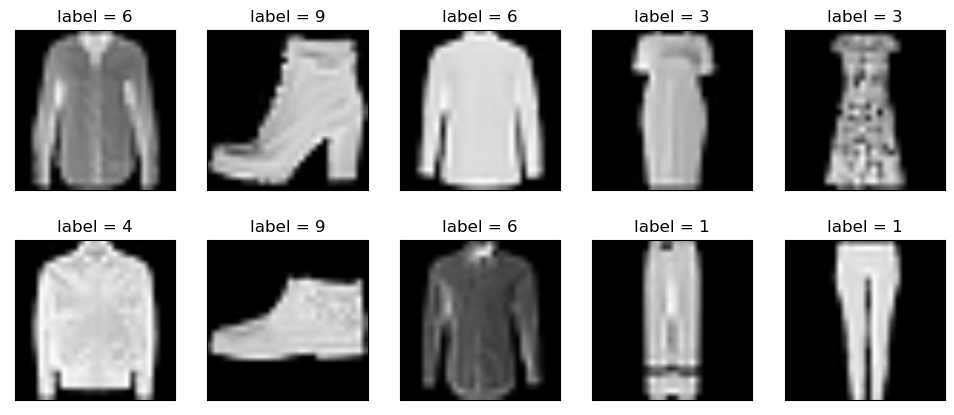

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
import random
from matplotlib import pyplot as plt
def denorm(img):
    for i in range(img.shape[0]):
        img[i] = img[i] * std[i] + mean[i]
    return img
plt.figure(figsize=(12, 5))
for i in range(10):
    img, label = train_dataset[random.randint(0, len(train_dataset))]
#     print(img.size())
    img = denorm(img)
    img = img.permute(1, 2, 0)
    ax = plt.subplot(2, 5, i + 1)
#     plt.imshow(img.squeeze(0), cmap='gray', interpolation='none')
    ax.imshow(img.numpy())
    ax.set_title("label = %d" % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


In [6]:
def U_TTN(params, wires):  # 2 params-------1√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_5(params, wires):  # 10 params-----------7√
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_6(params, wires):  # 10 params---------------8√
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])


def U_9(params, wires):  # 2 params-----------2√
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])


def U_13(params, wires):  # 6 params--------------4√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])


def U_14(params, wires):  # 6 params-------------5√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])


def U_15(params, wires):  # 4 params------------3√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def U_SO4(params, wires):  # 6 params------------6√
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])


def U_SU4(params, wires):  # 15 params----------------9√
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])


# Pooling Layer 池化层

def Pooling_ansatz1(params, wires):  # 2 params
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])


def Pooling_ansatz2(wires):  # 0 params
    qml.CRZ(wires=[wires[0], wires[1]])


def Pooling_ansatz3(*params, wires):  # 3 params
    qml.CRot(*params, wires=[wires[0], wires[1]])

In [7]:
# Convolutional layers
def conv_layer1(U, params):
    for i in range(0, 8, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
        U(params, wires=[i, i + 1])
    U(params, wires=[0, 7])

def conv_layer2(U, params):
    U(params, wires=[0, 2])
    U(params, wires=[4, 6])
    U(params, wires=[2, 4])
    U(params, wires=[0, 6])

# Pooling layers
def pooling_layer1(V, params):
    for i in range(0, 8, 2):
        V(params, wires=[i + 1, i])
        
def QCNN_structure(U, params, U_params):
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 2 * U_params + 2]

    conv_layer1(U, param1)
    pooling_layer1(Pooling_ansatz1, param3)
    conv_layer2(U, param2)

In [8]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, params, U, U_params):

    AmplitudeEmbedding(q_input_features, wires=range(8), normalize=True)
        
    if U == 'U_TTN':
        QCNN_structure(U_TTN, params, U_params)
    elif U == 'U_5':
        QCNN_structure(U_5, params, U_params)
    elif U == 'U_6':
        QCNN_structure(U_6, params, U_params)
    elif U == 'U_9':
        QCNN_structure(U_9, params, U_params)
    elif U == 'U_13':
        QCNN_structure(U_13, params, U_params)
    elif U == 'U_14':
        QCNN_structure(U_14, params, U_params)
    elif U == 'U_15':
        QCNN_structure(U_15, params, U_params)
    elif U == 'U_SO4':
        QCNN_structure(U_SO4, params, U_params)
    elif U == 'U_SU4':
        QCNN_structure(U_SU4, params, U_params)   
    
    else:
        print("Invalid Unitary Ansatze")
        return False

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in [0, 2, 4, 6]]
    return exp_vals
    

In [9]:
class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()        
        self.flat_net = nn.Flatten()
        self.pre_net = nn.Linear(512, 256)
        self.q_params = nn.Parameter(q_delta * torch.randn(totol_params))
        self.post_net = nn.Linear(4, 10)  # 10分类

    def forward(self, input_features):
        input_features = self.flat_net(input_features)
        pre_out = self.pre_net(input_features)
        
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        
        q_out = torch.Tensor(0, 4)
        q_out = q_out.to(device)

        for elem in q_in:
            q_out_elem = torch.Tensor(quantum_net(elem, self.q_params, U, U_p)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        q_final = self.post_net(q_out)
        
        return q_final

In [10]:
model_hybrid = torchvision.models.resnet18(pretrained=True)
for param in model_hybrid.parameters():
    param.requires_grad = False
model_hybrid.fc = DressedQuantumNet()

criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step, weight_decay=0.0001)


D:\Anaconda\envs\learn2023\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\learn2023\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def train_model(model, criterion, optimizer, num_epochs):

    print("Training started:")

    best_acc = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        for i,(inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            # print(ret)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            y_true=[]
            y_pred=[]
            for j, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)

                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(predictions.cpu().numpy().tolist())

        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size

        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(model, 'Result/TL-HQCCNN_Fashion-MNIST_5000.pth')


        epoch_end = time.time()

        print(
            "\t Training: Loss: {:.4f}, Accuracy: {:.4f}%, "
            "\n\t Validation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.3f}s".format(
                avg_train_loss, avg_train_acc * 100, avg_valid_loss, avg_valid_acc * 100,
                                epoch_end - epoch_start
            ))
        print("\t Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
        train_all_loss.append(avg_train_loss)
        train_all_acc.append(avg_train_acc)
        val_all_loss.append(avg_valid_loss)
        val_all_acc.append(avg_valid_acc)
        best_accuracy=best_acc

In [12]:
train_model(model_hybrid, criterion, optimizer_hybrid, num_epochs)

Training started:
Epoch: 1/50
	 Training: Loss: 2.1027, Accuracy: 29.4667%, 
	 Validation: Loss: 1.7897, Accuracy: 59.7000%, Time: 545.300s
	 Best Accuracy for validation : 0.5970 at epoch 001
Epoch: 2/50
	 Training: Loss: 1.6173, Accuracy: 58.1333%, 
	 Validation: Loss: 1.4279, Accuracy: 64.6000%, Time: 549.753s
	 Best Accuracy for validation : 0.6460 at epoch 002
Epoch: 3/50
	 Training: Loss: 1.3408, Accuracy: 62.4333%, 
	 Validation: Loss: 1.2032, Accuracy: 69.7000%, Time: 547.321s
	 Best Accuracy for validation : 0.6970 at epoch 003
Epoch: 4/50
	 Training: Loss: 1.1629, Accuracy: 67.2667%, 
	 Validation: Loss: 1.0687, Accuracy: 74.5000%, Time: 546.495s
	 Best Accuracy for validation : 0.7450 at epoch 004
Epoch: 5/50
	 Training: Loss: 1.0279, Accuracy: 72.7000%, 
	 Validation: Loss: 0.9782, Accuracy: 74.7000%, Time: 549.825s
	 Best Accuracy for validation : 0.7470 at epoch 005
Epoch: 6/50
	 Training: Loss: 0.9502, Accuracy: 75.2333%, 
	 Validation: Loss: 0.8984, Accuracy: 77.5000%, 

	 Training: Loss: 0.3206, Accuracy: 91.2333%, 
	 Validation: Loss: 0.4847, Accuracy: 84.7000%, Time: 469.660s
	 Best Accuracy for validation : 0.8520 at epoch 041
Epoch: 49/50
	 Training: Loss: 0.2992, Accuracy: 92.1000%, 
	 Validation: Loss: 0.4838, Accuracy: 84.2000%, Time: 468.901s
	 Best Accuracy for validation : 0.8520 at epoch 041
Epoch: 50/50
	 Training: Loss: 0.3198, Accuracy: 90.9667%, 
	 Validation: Loss: 0.4974, Accuracy: 84.4000%, Time: 468.321s
	 Best Accuracy for validation : 0.8520 at epoch 041


In [13]:
print(train_all_loss)
print(train_all_acc)
print(val_all_loss)
print(val_all_acc)

[2.1026992451349895, 1.6173080860773723, 1.3408461135228475, 1.1628760296503702, 1.0278650738398234, 0.9501887515385946, 0.9159856103261312, 0.8350670959154765, 0.7931274902025859, 0.7616490658124287, 0.6999045988718668, 0.6779521342913309, 0.6811448868115743, 0.6332157085736593, 0.602971847375234, 0.5941004185676575, 0.5957170144716899, 0.5600241545041402, 0.549434603770574, 0.554438116312027, 0.5131615688006084, 0.5230207765102386, 0.508584817091624, 0.5086022542317709, 0.4864532471497854, 0.45451960428555804, 0.4373866601785024, 0.42074512235323586, 0.4253659478028615, 0.4050181192557017, 0.41766436330477397, 0.4122803041934967, 0.38916272890567777, 0.3800110365549723, 0.3763161954085032, 0.3784716333548228, 0.362520312945048, 0.3516139396031698, 0.34424506131807964, 0.36906126952171325, 0.35705084896087647, 0.36405362582206724, 0.3443257296880086, 0.3450022659301758, 0.3155396523475647, 0.3145851445992788, 0.2992028532822927, 0.3206473001241684, 0.29918519632021584, 0.3197996010382

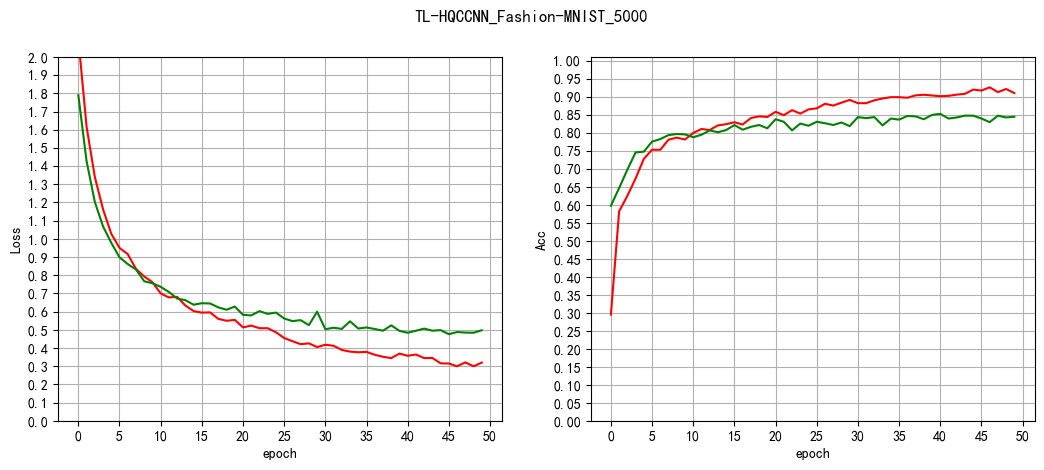

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

x = np.arange(0, 50)

width, height = 32, 12 
fig = plt.figure()
fig.suptitle("TL-HQCCNN_Fashion-MNIST_5000", fontsize=12)

fig.set_size_inches(width / 2.54, height / 2.54)

plt.subplot(1, 2, 1)  # fig.1是一个一行两列布局的图，且现在画的是左图
loss_1 = train_all_loss
loss_2 = val_all_loss
line1, = plt.plot(x, loss_1, color='r')
line2, = plt.plot(x, loss_2, color='g')
# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Loss")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0, 2.0001, 0.1))
plt.ylim(0, 2)


plt.subplot(1, 2, 2)  # 当前图变为fig.1的右图
acc_1 = train_all_acc
acc_2 = val_all_acc

line1, = plt.plot(x, acc_1, color='r')
line2, = plt.plot(x, acc_2, color='g')

# 添加网格
plt.grid(visible=True, axis='x')  # 只显示x轴网格线
plt.grid(visible=True, axis='y')  # 只显示y轴网格线

plt.xlabel("epoch")
plt.ylabel("Acc")

plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0.0, 1.01, 0.05))
plt.ylim(0.0, 1.01)

plt.show()


In [15]:
model_Q = torch.load( 'Result/TL-HQCCNN_Fashion-MNIST_5000.pth', map_location=device)
model_Q.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
print('TL-HQCCNN_Fashion-MNIST_5000')

totel_acc=0.0

for j, (inputs, labels) in enumerate(test_dataloader):
    outputs = model_Q(inputs)
    ret, predictions = torch.max(outputs.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    totel_acc += acc.item() * inputs.size(0)
print('测试集1000：')
print(totel_acc/test_data_size)


TL-HQCCNN_Fashion-MNIST_5000
测试集1000：
0.826
